In [136]:
import pandas as pd

h5 = '/lab/weissman_imaging/amyzheng/MERFISH_analysis/20260112_124506_037_run1/Decode/barcodes/barcode_data_0.h5'

with pd.HDFStore(h5, "r") as store:
    print("keys:", store.keys())
    key = store.keys()[0]
df = pd.read_hdf(h5, key=key)

print(df.shape)
print(df.columns.tolist()[:60])
print(df.head(3))


keys: ['/barcodes']
(25929252, 28)
['barcode_id', 'fov', 'mean_intensity', 'max_intensity', 'area', 'mean_distance', 'min_distance', 'x', 'y', 'z', 'global_x', 'global_y', 'global_z', 'cell_index', 'intensity_0', 'intensity_1', 'intensity_2', 'intensity_3', 'intensity_4', 'intensity_5', 'intensity_6', 'intensity_7', 'intensity_8', 'intensity_9', 'intensity_10', 'intensity_11', 'intensity_12', 'intensity_13']
     barcode_id  fov  mean_intensity  max_intensity  area  mean_distance  \
658           0    0        1.041065       1.041065     1       0.646454   
659           0    0        1.281910       1.281910     1       0.600713   
660           0    0        2.609320       2.609320     1       0.558345   

     min_distance      x     y    z  ...  intensity_4  intensity_5  \
658      0.646454  207.0  91.0  0.0  ...     0.807559     0.000000   
659      0.600713  287.0  91.0  0.0  ...     0.047988     0.000000   
660      0.558345  776.0  91.0  0.0  ...     0.275048     0.135015   

  

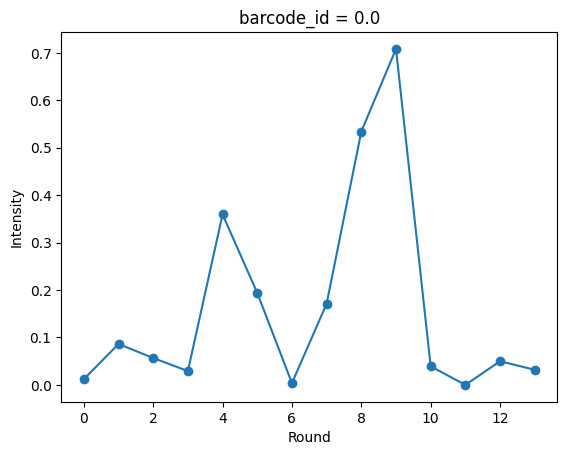

In [47]:
row = df.iloc[100]
vals = row[[c for c in df.columns if c.startswith("intensity_")]]

plt.plot(vals.values, marker="o")
plt.xlabel("Round")
plt.ylabel("Intensity")
plt.title(f"barcode_id = {row.barcode_id}")
plt.show()


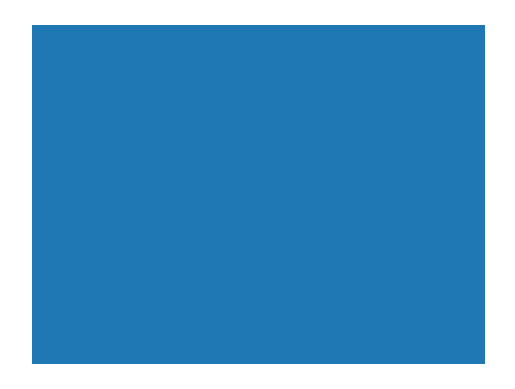

In [48]:
xy = df[["x", "y"]].to_numpy(float)   
plt.figure()
plt.scatter(xy[:, 0], xy[:, 1], s=1, alpha=0.4)  # don't set color
plt.axis("off")
plt.show()

In [49]:
df = pd.read_csv('/lab/weissman_imaging/amyzheng/MERFISH_analysis/20260112_124506_037_run1/codebook_0_SC1_codebook_trimmed.csv')
stv_cols = [c for c in df.columns if c.startswith("Stv")]
pattern = [0, 0,0,0,1,0,0,0,1,0,0,0,1, 0]
mask = (df[stv_cols] == pattern).all(axis=1)
matches = df[mask]

In [50]:
print(matches)

Empty DataFrame
Columns: [name, id, Stv_3, Stv_4, Stv_5, Stv_6, Stv_7, Stv_8, Stv_9, Stv_10, Stv_11, Stv_12, Stv_13, Stv_14, Stv_16, Stv_19]
Index: []


In [51]:
import numpy as np

intensity_cols = [c for c in df.columns if c.startswith("intensity_")]
stv_cols = [c for c in df.columns if c.startswith("Stv")]

ref = df.iloc[100][intensity_cols].to_numpy(dtype=float)
stv = df[stv_cols].to_numpy(dtype=float)

# Euclidean distances
dists = np.linalg.norm(stv - ref, axis=1)

# argmin (row index)
i_min = np.argmin(dists)

i_min, dists[i_min], df.iloc[i_min]


IndexError: single positional indexer is out-of-bounds

In [79]:
import numpy as np
import pandas as pd

codebook_path = '/lab/weissman_imaging/amyzheng/MERFISH_analysis/20241104-4T1FE_1101_Mf4dna/codebook_0_MF4dna_codebook.csv'
cb = pd.read_csv(codebook_path)

stv_cols = [c for c in cb.columns if c.startswith("Stv")]
assert len(stv_cols) > 0, "No Stv* columns found in codebook"

first_stv = stv_cols[0]  # first bit by CSV order
cb_firstbit1_ids = set(cb.index[cb[first_stv].astype(int) == 1].to_numpy())

print("First Stv column:", first_stv)
print("How many codebook rows have first bit=1:", len(cb_firstbit1_ids))


First Stv column: Stv_29
How many codebook rows have first bit=1: 34


In [38]:
import pandas as pd

In [160]:
h5 = '/lab/weissman_imaging/amyzheng/MERFISH_analysis/20260112_124506_037_run1/Decode/barcodes/barcode_data_0.h5'
df = pd.read_hdf(h5, key="/barcodes")

print("barcode_id min/max:", df["barcode_id"].min(), df["barcode_id"].max())
print("n unique barcode_id:", df["barcode_id"].nunique())
print("codebook rows:", len(cb))

barcode_id min/max: 0 75
n unique barcode_id: 76
codebook rows: 76


In [208]:
# Distance cutoff (tune this)
DIST_MAX =0.5
USE_MEAN_DISTANCE = False 
MIN_AREA =4       
MIN_MEAN_INT = None     

dist_col = "mean_distance" if USE_MEAN_DISTANCE else "min_distance"

mask = df["barcode_id"].isin(cb_firstbit1_ids)
mask &= df[dist_col].to_numpy(float) <= float(DIST_MAX)

if MIN_AREA is not None:
    mask &= df["area"].to_numpy(float) >= float(MIN_AREA)

if MIN_MEAN_INT is not None:
    mask &= df["mean_intensity"].to_numpy(float) >= float(MIN_MEAN_INT)

# Keep columns you need for plotting
df_bit1 = df.loc[mask, ["x", "y", "z", "barcode_id", "fov", "min_distance", "mean_intensity", "area"]].copy()

print("filtered rows:", len(df_bit1))
print("distance column used:", dist_col)
print("min/max distance in filtered set:", df_bit1[dist_col].min(), df_bit1[dist_col].max())

filtered rows: 4611
distance column used: min_distance
min/max distance in filtered set: 0.053402353 0.49999428


In [190]:
# mask = df["barcode_id"].isin(cb_firstbit1_ids)
# df_bit1 = df.loc[mask, ["x", "y", "z", "barcode_id", "fov"]]

# print("filtered rows:", len(df_bit1))


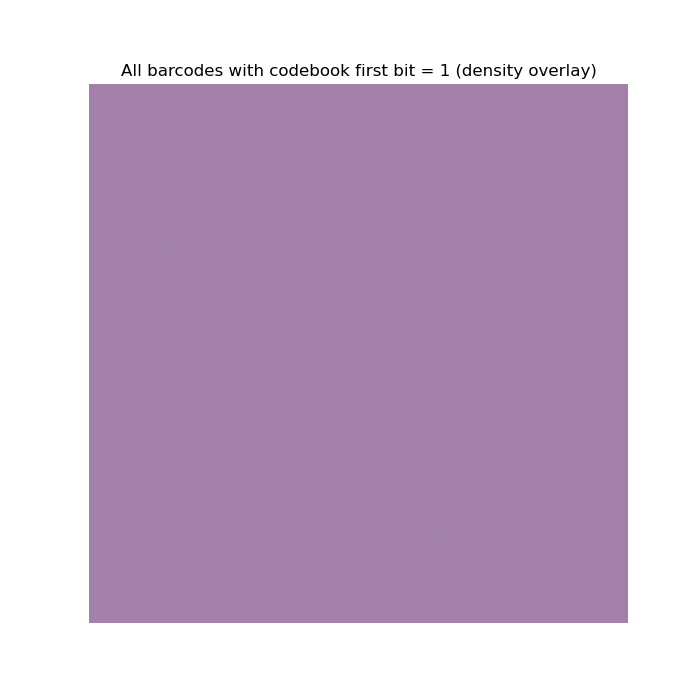

In [201]:
import numpy as np
import matplotlib.pyplot as plt


x = df_bit1["x"].to_numpy()
y = df_bit1["y"].to_numpy()
z = df_bit1["z"].to_numpy()

# 2D count map: rows=y, cols=x
heat = np.zeros((H, W), dtype=np.uint32)
np.add.at(heat, (y.astype(np.int64), x.astype(np.int64)), 1)

plt.figure(figsize=(7,7))
# plt.imshow(img0, cmap="gray")
plt.imshow(np.log1p(heat), alpha=0.5)   # log scale helps dynamic range
plt.axis("off")
plt.title("All barcodes with codebook first bit = 1 (density overlay)")
plt.show()


In [179]:
from file_io.dax_process import DaxProcesser
from visual_tools.interactive import imshow_mark_3d

In [192]:
import os
data_folder = '/lab/weissman_imaging/puzheng/4T1Tumor/20241104-4T1FE_1101_Mf4dna'
image_folder = os.path.join(data_folder, r'H0M1')

image_basenames = sorted([_fl for _fl in os.listdir(image_folder) if _fl.split(os.extsep)[-1] =='dax'])
print(image_folder)
if len(image_basenames) < 20:
    print(image_basenames)
else:
    print(image_basenames[-20:])

image_filename = os.path.join(image_folder, image_basenames[0]) #select fov here

daxp = DaxProcesser(image_filename
                   )
daxp._load_image()

/lab/weissman_imaging/puzheng/4T1Tumor/20241104-4T1FE_1101_Mf4dna/H0M1
['Conv_zscan_26.dax', 'Conv_zscan_27.dax', 'Conv_zscan_28.dax', 'Conv_zscan_29.dax', 'Conv_zscan_30.dax', 'Conv_zscan_31.dax', 'Conv_zscan_32.dax', 'Conv_zscan_33.dax', 'Conv_zscan_34.dax', 'Conv_zscan_35.dax', 'Conv_zscan_36.dax', 'Conv_zscan_37.dax', 'Conv_zscan_38.dax', 'Conv_zscan_39.dax', 'Conv_zscan_40.dax', 'Conv_zscan_41.dax', 'Conv_zscan_42.dax', 'Conv_zscan_43.dax', 'Conv_zscan_44.dax', 'Conv_zscan_45.dax']
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20241104-4T1FE_1101_Mf4dna/H0M1/Conv_zscan_00.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20241104-4T1FE_1101_Mf4dna/H0M1/Conv_zscan_00_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['748', '637', '477', '405'] in 0.601s.


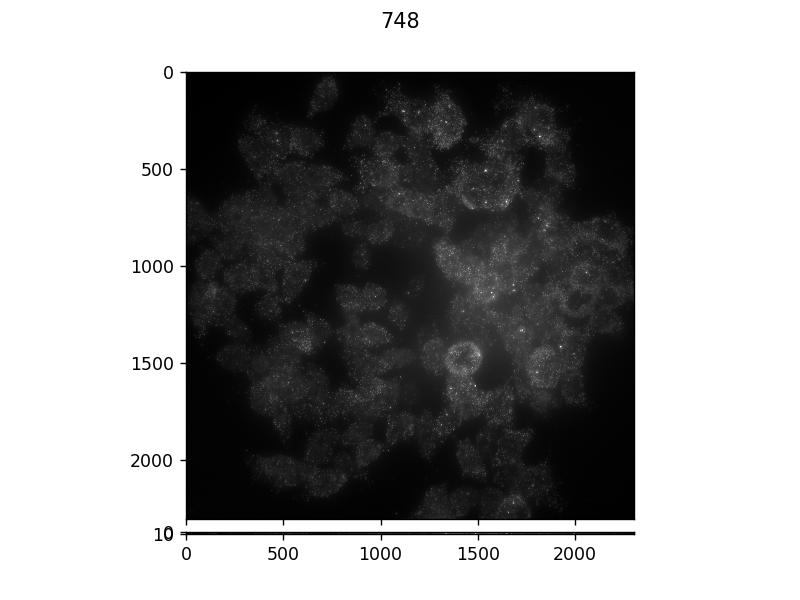

In [202]:
import matplotlib.pyplot as plt
%matplotlib widget
f = plt.figure(dpi=125)
imshow_mark_3d([getattr(daxp, f"im_{_ch}")[:] for _ch in daxp.channels], 
                fig=f,
                image_names=daxp.channels, 
                min_max_default=[500,5000],
                )

In [182]:
Z0 = 10   # 0..20
C0 = 0
with nd2.ND2File(nd2_path) as f:
    stack = f.asarray()        # shape (Z, C, Y, X)
    img2d = stack[Z0, C0]      # shape (Y, X)

print(img2d.shape, img2d.dtype)

(2304, 2304) uint16


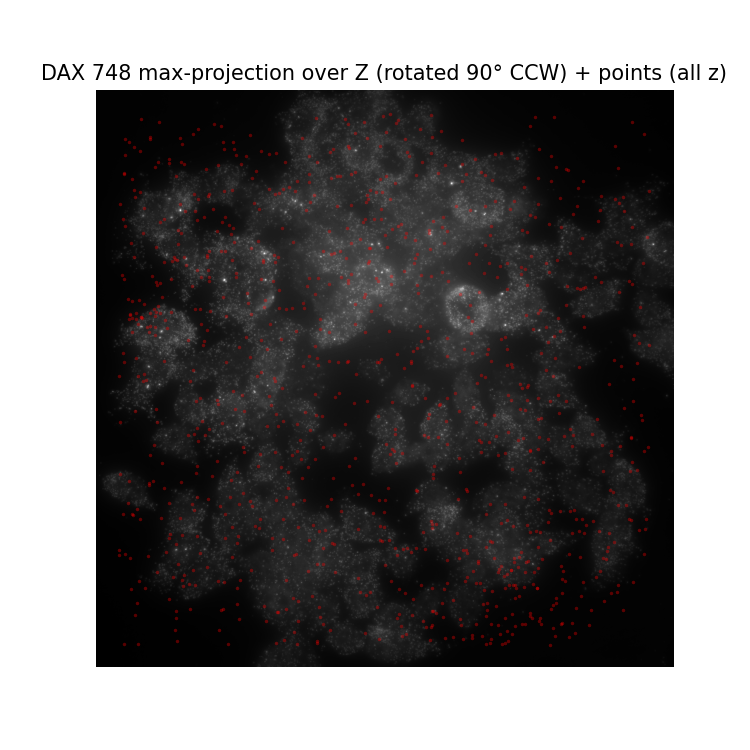

In [198]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt


dax_ch = "748"

# Full DAX volume: (Z, Y, X)
dax_vol = getattr(daxp, f"im_{dax_ch}")[:].astype(np.float32)

# Max projection over Z
dax_max = dax_vol.max(axis=0)   # (Y, X)

# Rotate ONLY the DAX image 90° counter-clockwise
dax_max_ccw = np.rot90(dax_max, k=1)  # (X, Y) -> shape (W, H)


FOV0 = 0
pts = df_bit1[df_bit1["fov"] == FOV0]   # all z
x = pts["x"].to_numpy(float)            # unchanged
y = pts["y"].to_numpy(float)            # unchanged


H2, W2 = dax_max_ccw.shape
m_in = (x >= 0) & (x < W2) & (y >= 0) & (y < H2)
x = x[m_in]
y = y[m_in]


fig, ax = plt.subplots(figsize=(6, 6), dpi=125)

ax.imshow(dax_max_ccw, cmap="gray", origin="upper")
ax.scatter(
    x, y,
    s=4,
    c="red",
    alpha=0.35,
    linewidths=0,
    rasterized=True
)

ax.set_title(f"DAX {dax_ch} max-projection over Z (rotated 90° CCW) + points (all z)")
ax.set_xlim(0, W2)
ax.set_ylim(H2, 0)
ax.axis("off")

plt.show()


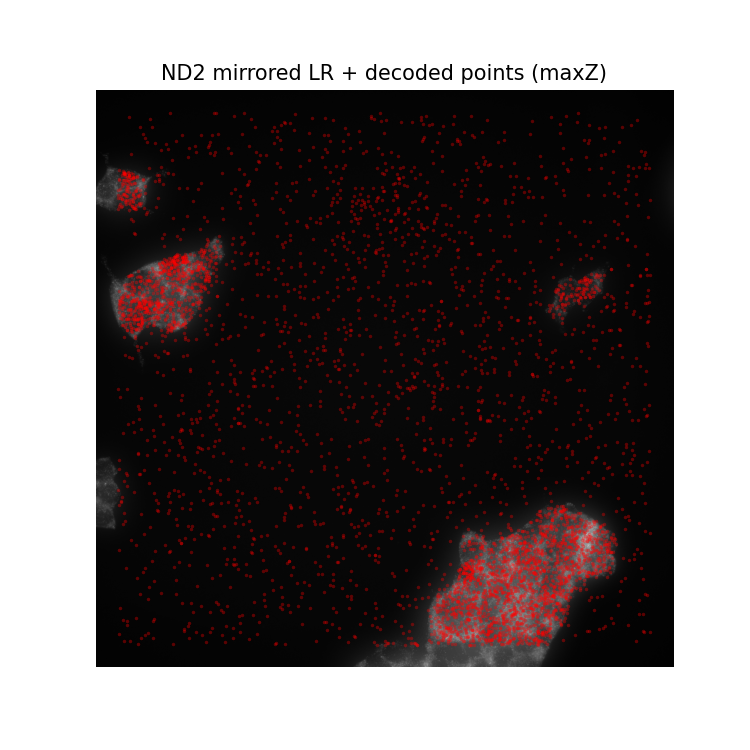

In [210]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import nd2

nd2_path ='/lab/weissman_imaging/puzheng/TMD/20260112-HEK-LP_SC1_multiIF/20260112_124506_037/Conv_Hyb0_0.nd2'
C0 = 0
USE_MAX_Z = True
Z0 = 10

FOV0 = 0
pts = df_bit1[df_bit1["fov"] == FOV0]
x = pts["x"].to_numpy(float)
y = pts["y"].to_numpy(float)


with nd2.ND2File(nd2_path) as f:
    stack = f.asarray().astype(np.float32)
    if USE_MAX_Z:
        img2d = stack[:, C0].max(axis=0)
        title_z = "maxZ"
    else:
        img2d = stack[Z0, C0]
        title_z = f"Z={Z0}"


img2d_mirror = np.fliplr(img2d)


fig, ax = plt.subplots(figsize=(6, 6), dpi=125)

ax.imshow(img2d_mirror, cmap="gray", origin="upper")
ax.scatter(
    x, y,
    s=4,
    c="red",
    alpha=0.35,
    linewidths=0,
    rasterized=True
)

ax.set_title(f"ND2 mirrored LR + decoded points ({title_z})")
ax.set_xlim(0, W)
ax.set_ylim(H, 0)
ax.axis("off")

plt.show()


In [170]:

# 1) How many are single-pixel?
print("fraction area==1:", (df["area"] == 1).mean())

# 2) Distance distribution
print(df["min_distance"].describe())

# 3) If you apply a strict filter, do points collapse onto real structures?
strict = (df["area"] >= 3) & (df["mean_intensity"] >= 200) & (df["min_distance"] <= 0.6)
print("kept fraction strict:", strict.mean())


fraction area==1: 0.923721902968894
count    2.592925e+07
mean     5.794050e-01
std      6.409216e-02
min      2.129720e-02
25%      5.523865e-01
50%      5.968784e-01
75%      6.262110e-01
max      6.500000e-01
Name: min_distance, dtype: float64
kept fraction strict: 2.1211564452379883e-06


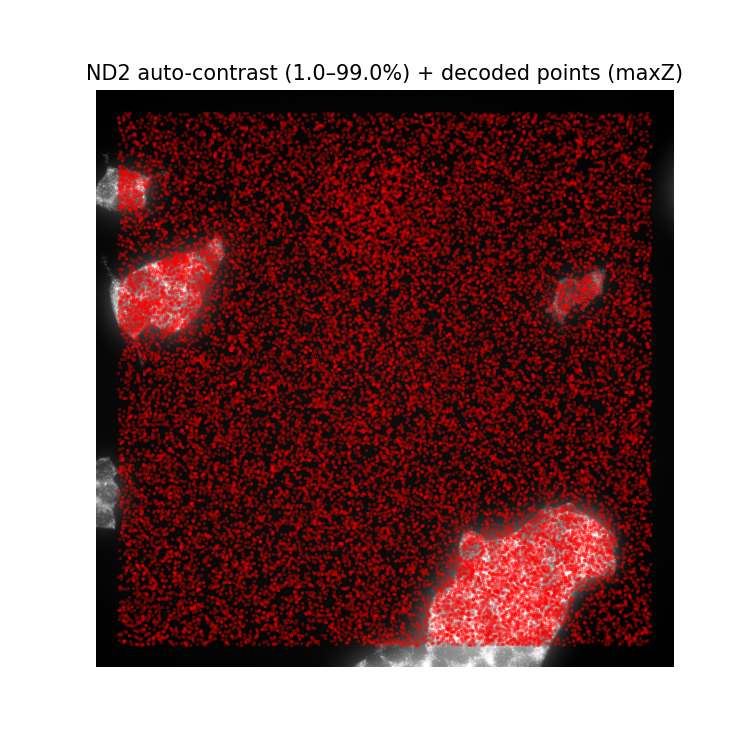

In [207]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import nd2


nd2_path = '/lab/weissman_imaging/puzheng/TMD/20260112-HEK-LP_SC1_multiIF/20260112_124506_037/Conv_Hyb0_0.nd2'
C0 = 0
USE_MAX_Z = True
Z0 = 10

# Auto-contrast percentiles
P_LOW  = 1.0
P_HIGH = 99.0

# Decoded points
FOV0 = 0
pts = df_bit1[df_bit1["fov"] == FOV0]
x = pts["x"].to_numpy(float)
y = pts["y"].to_numpy(float)

# ----------------------------
# Load ND2 and project
# ND2 shape: (Z, C, Y, X)
# ----------------------------
with nd2.ND2File(nd2_path) as f:
    stack = f.asarray().astype(np.float32)
    if USE_MAX_Z:
        img2d = stack[:, C0].max(axis=0)
        title_z = "maxZ"
    else:
        img2d = stack[Z0, C0]
        title_z = f"Z={Z0}"

# ----------------------------
# Mirror image (left-right)
# ----------------------------
img2d = np.fliplr(img2d)


vmin, vmax = np.percentile(img2d, [P_LOW, P_HIGH])
img2d_ac = np.clip(img2d, vmin, vmax)
img2d_ac = (img2d_ac - vmin) / (vmax - vmin + 1e-8)

H, W = img2d_ac.shape

# Keep only valid points
m = (x >= 0) & (x < W) & (y >= 0) & (y < H)
x = x[m]
y = y[m]

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(6, 6), dpi=125)

ax.imshow(img2d_ac, cmap="gray", origin="upper")
ax.scatter(
    x, y,
    s=4,
    c="red",
    alpha=0.35,
    linewidths=0,
    rasterized=True
)

ax.set_title(
    f"ND2 auto-contrast ({P_LOW}–{P_HIGH}%) + decoded points ({title_z})"
)
ax.set_xlim(0, W)
ax.set_ylim(H, 0)
ax.axis("off")

plt.show()


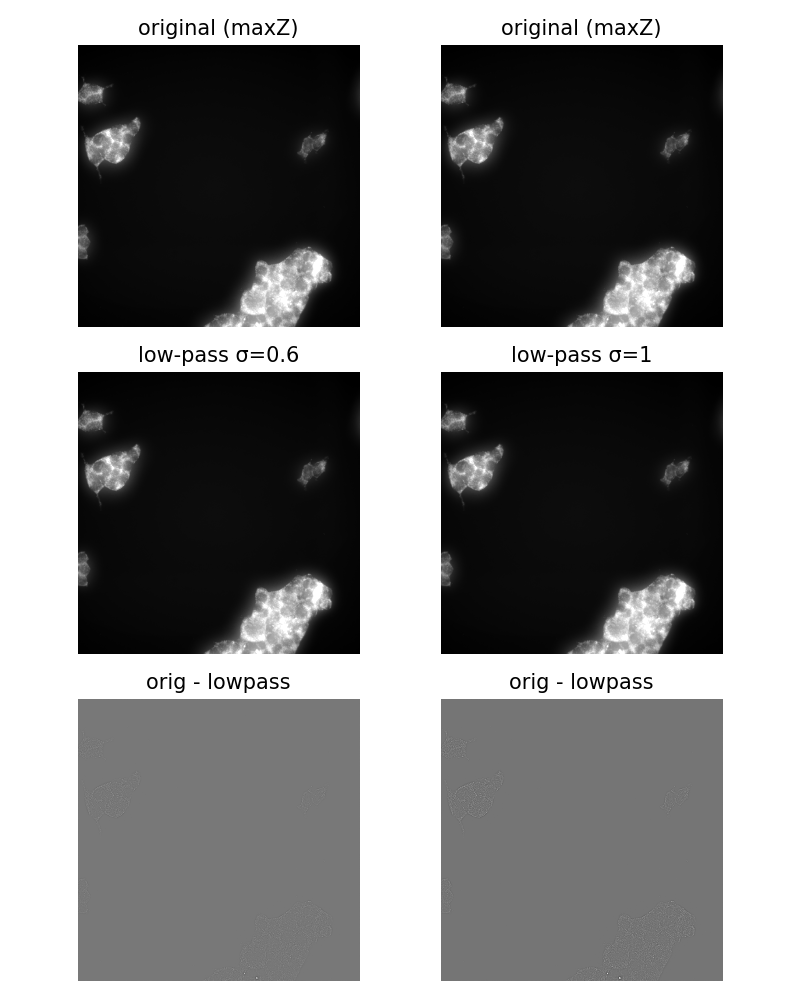

In [215]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import nd2
import cv2

nd2_path = "/lab/weissman_imaging/puzheng/TMD/20260112-HEK-LP_SC1_multiIF/20260112_124506_037/Conv_Hyb1_0.nd2"
C0 = 0
USE_MAX_Z = True
Z0 = 10

with nd2.ND2File(nd2_path) as f:
    stack = f.asarray().astype(np.float32)
    if USE_MAX_Z:
        img2d = stack[:, C0].max(axis=0)
        title_z = "maxZ"
    else:
        img2d = stack[Z0, C0]
        title_z = f"Z={Z0}"

img2d_mirror = np.fliplr(img2d)

def merlin_lowpass_2d(img: np.ndarray, lowPassSigma: float) -> np.ndarray:
    if lowPassSigma is None or lowPassSigma <= 0:
        return img.astype(np.float32, copy=False)
    filterSize = int(2 * np.ceil(2 * lowPassSigma) + 1)
    filterSize = max(3, filterSize | 1)  # odd, >=3
    return cv2.GaussianBlur(img.astype(np.float32, copy=False),
                            (filterSize, filterSize),
                            lowPassSigma)

def robust_vmin_vmax(im, lo=1, hi=99):
    vmin, vmax = np.percentile(im, [lo, hi])
    return float(vmin), float(vmax)

sigmas = [0.6, 1]
vmin, vmax = robust_vmin_vmax(img2d_mirror, 0.5, 99.5)

# IMPORTANT FIX:
# If n==1, matplotlib returns a 1D array; force 2D with squeeze=False
n = len(sigmas)
fig, axes = plt.subplots(3, n, figsize=(3.2*n, 8), dpi=125, squeeze=False)

for j, s in enumerate(sigmas):
    filt = merlin_lowpass_2d(img2d_mirror, s)
    resid = img2d_mirror - filt

    axes[0, j].imshow(img2d_mirror, cmap="gray", origin="upper", vmin=vmin, vmax=vmax)
    axes[0, j].set_title(f"original ({title_z})")
    axes[0, j].axis("off")

    axes[1, j].imshow(filt, cmap="gray", origin="upper", vmin=vmin, vmax=vmax)
    axes[1, j].set_title(f"low-pass σ={s}")
    axes[1, j].axis("off")

    rvmin, rvmax = robust_vmin_vmax(resid, 1, 99)
    axes[2, j].imshow(resid, cmap="gray", origin="upper", vmin=rvmin, vmax=rvmax)
    axes[2, j].set_title("orig - lowpass")
    axes[2, j].axis("off")

plt.tight_layout()
plt.show()
